# **SimpleShot for Few-Shot Learning on CIFAR-100**

This notebook demonstrates **SimpleShot**, a **feature-based** few-shot learner on a base/novel split of **CIFAR-100**. The approach is non-parametric at test time:
1. A frozen encoder extracts embeddings
2. A light transformation improves comparability between base and novel distributions
3. Class prototypes are computed on the fly
4. Queries are classified by cosine similarity to those prototypes.

We follow the same episodic evaluation framing used in the Prototypical Networks demo so that concepts and results are directly comparable.

---

## **1. Background**

### **1.1 Few-Shot Learning (FSL)**

In FSL, a model is evaluated on **episodes**. Each episode samples $N$ classes (N-way). For each class $k$, a **support set** $S_k$ of size $K$ (K-shot) is provided along with a **query set** $Q_k$. The learner must assign each query to one of the $N$ classes using only the $N\times K$ labeled supports available in that episode. This episodic protocol encourages generalization to new categories with minimal supervision and gives stable statistics when averaging accuracy over many episodes, as in the ProtoNet notebook.

### **1.2 From Metric Learning to SimpleShot**

Metric-based FSL typically uses an encoder $f(\cdot)$ that maps images to a feature space where same-class points are close and different-class points are separated. **SimpleShot** adopts an extremely light-weight recipe:
1. It freezes a strong, pretrained encoder;
2. It **centers** embeddings by subtracting the mean feature computed on base classes;
3. It **normalizes** them with $\ell_2$;
4. It builds a prototype per class as the average of support embeddings;
5. It classifies queries by cosine similarity to those prototypes.

This keeps computation minimal while leveraging the inductive bias of the pretrained backbone and a simple distribution alignment step. In spirit it mirrors the metric classification of ProtoNets, but **without meta-training**.

### **1.3 Dataset and Split**

We use **CIFAR-100** with an **image-net-style** preprocessing pipeline because the encoder is a ResNet-18 pretrained on ImageNet.

Images are resized to $256$, center-cropped to $224$, converted to tensors, and normalized with ImageNet statistics $\mu=[0.485,0.456,0.406]$ and $\sigma=[0.229,0.224,0.225]$.

Classes are partitioned into **base** and **novel**: in this notebook the split is $70/30$ by class index, with base $=\{0,\dots,69\}$ and novel $=\{70,\dots,99\}$. Base images are used to estimate the feature mean, while few-shot episodes are drawn from novel classes for evaluation.

---

## **2. Practice**

### **2.1 Environment**

We set global seeds for NumPy, Python’s `random`, and PyTorch to keep episode sampling and inference consistent. We choose the device automatically; when CUDA is available, inference and feature computation run on GPU. The episodic configuration mirrors the ProtoNet demo, with variables such as `N_WAY`, `K_SHOT`, `Q_QUERY`, and `N_EVAL_TASKS` controlling task shape and the number of episodes over which we average.

In [1]:
import random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

In [2]:
# Reproducibility
SEED = 42
rng = np.random.default_rng(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Episodic configuration
N_WAY = 5
K_SHOT = 5
Q_QUERY = 10
N_EVAL_TASKS= 100

#### **2.1.1 CIFAR-100 and Transforms**

The notebook downloads CIFAR-100 and applies the deterministic **eval** transform defined above to both train and test splits, ensuring feature comparability across base and novel. This is appropriate for a **frozen** backbone: we are not doing data augmentation to improve training, only standardizing inputs to match the encoder’s pretraining regime.

In [5]:
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

In [6]:
train_set = torchvision.datasets.CIFAR100("./data", train=True,  download=True, transform=transform_eval)
test_set  = torchvision.datasets.CIFAR100("./data", train=False, download=True, transform=transform_eval)

# standard split base/novel (70/30)
base_cls, novel_cls = list(range(0,70)), list(range(70,100))
train_idx_base = [i for i,(_,y) in enumerate(train_set) if y in base_cls]
test_idx_novel = [i for i,(_,y) in enumerate(test_set)  if y in novel_cls]

ds_base  = Subset(train_set, train_idx_base)  # estimate SimpleShot mean
ds_novel = Subset(test_set,  test_idx_novel)  # to construct few-shot episodes
label_names = train_set.classes
print(f"#base images: {len(ds_base)} | #novel images: {len(ds_novel)}")

#base images: 35000 | #novel images: 3000


#### **2.1.2 Base/Novel Split and Episodic Sampling**

We extract indices for **base** images from the training split and **novel** images from the test split. The base subset `ds_base` feeds the mean-estimation step; the novel subset `ds_novel` is the pool from which we sample few-shot episodes. Sampling proceeds by picking $N$ novel classes uniformly at random, then drawing $K+Q$ images per class and remapping their original dataset labels to episodic labels $\{0,\dots,N-1\}$. Episodes are i.i.d.; mean accuracy and a 95% confidence interval are reported across `N_EVAL_TASKS` episodes.

#### **2.1.3 The SimpleShot Module**

We encapsulate SimpleShot as a PyTorch module with a clear life cycle: initialize with a frozen backbone; call `fit_base` once to estimate the base mean; call `forward` episodically with support images, support labels, and query images. The core computations are:

1. **Mean estimation on base**:

$$
\mu_{\text{base}} \;=\; \frac{1}{N_{\text{base}}} \sum_{i} f(x_i)
$$

computed over all base images via a standard `DataLoader`, with the backbone in `eval()` and BatchNorm frozen.

2. **SimpleShot transform**: for any embedding $z=f(x)$,

$$
\tilde{z} \;=\; \mathrm{norm}\bigl(z \;-\; \mu_{\text{base}}\bigr),\qquad
\mathrm{norm}(u) \;=\; \frac{u}{\lVert u\rVert_2}
$$

applied to both support and query features.

3. **Class prototypes**: for each episodic class $k$ with supports $S_k$,

$$
c_k \;=\; \frac{1}{\lvert S_k\rvert}\sum_{(x,y)\in S_k} \tilde{z}(x),\qquad
c_k \leftarrow \frac{c_k}{\lVert c_k\rVert_2}
$$

4. **Cosine-based logits and prediction**: for a query $x$,

$$
\text{logit}_k(x) \;=\; \tilde{z}(x)^\top c_k,\qquad
\hat{y}(x) \;=\; \arg\max_k \text{logit}_k(x)
$$

This mirrors ProtoNets’ prototype logic but removes meta-training; the only “fit” stage is the base-mean estimation.

In [7]:
class SimpleShotProto(nn.Module):
    """
    SimpleShot module:
      - freezed backbone (feature extractor)
      - base_mean estimated on base classes (fit_base)
      - transformation: (z - base_mean) then (optional) L2
      - forward: compute support prototypes and logits cosine for queries
    """
    def __init__(self, backbone: nn.Module, use_centering=True, use_l2=True, device="cpu"):
        super().__init__()
        self.backbone = backbone.eval()
        for p in self.backbone.parameters():
            p.requires_grad = False
        self.use_centering = use_centering
        self.use_l2 = use_l2
        self.device = torch.device(device)
        D = 512   # backbone embedding dim (resnet18 -> 512)
        self.register_buffer("base_mean", torch.zeros(1, D))
        self.register_buffer("has_mean", torch.tensor(0, dtype=torch.uint8))
        self.to(self.device)

    @torch.no_grad()
    def _encode(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(self.device, non_blocking=True)
        z = self.backbone(x)          # (B, D)
        return z

    @torch.no_grad()
    def fit_base(self, base_loader: DataLoader) -> torch.Tensor:
        feats = []
        for xb, _ in base_loader:
            feats.append(self._encode(xb).cpu())
        Z = torch.cat(feats, 0) if feats else torch.empty(0)
        mean = Z.mean(0, keepdim=True) if Z.numel() else torch.zeros(1, self.base_mean.size(1))
        self.base_mean.copy_(mean.to(self.device))
        self.has_mean[...] = 1
        return self.base_mean

    @torch.no_grad()
    def _transform(self, z: torch.Tensor) -> torch.Tensor:
        Z = z
        if self.use_centering and bool(self.has_mean.item()):
            Z = Z - self.base_mean.to(z.device)
        if self.use_l2:
            Z = F.normalize(Z, p=2, dim=1)
        return Z

    @staticmethod
    @torch.no_grad()
    def _compute_prototypes(z_support: torch.Tensor, y_support: torch.Tensor):
        classes = torch.unique(y_support)
        protos = [z_support[y_support == c].mean(0, keepdim=True) for c in classes]
        proto  = torch.cat(protos, 0)            # (N_way, D)
        return proto, classes

    @torch.no_grad()
    def forward(self, support_images, support_labels, query_images):
        # 1) Encode -> 2) SimpleShot transform
        zS = self._transform(self._encode(support_images))
        zQ = self._transform(self._encode(query_images))
        # 3) Prototypes
        proto, classes = self._compute_prototypes(zS, support_labels.to(zS.device))
        # 4) Logits = cosine sim (dot on L2)
        if self.use_l2:
          proto = F.normalize(proto, p=2, dim=1)
        if not self.use_l2:
            zQ = F.normalize(zQ, p=2, dim=1)
            proto = F.normalize(proto, p=2, dim=1)
        logits = zQ @ proto.T                   # (Nq, N_way)
        return logits, classes

weights = ResNet18_Weights.IMAGENET1K_V1
backbone = resnet18(weights=weights)
backbone.fc = nn.Identity()
model = SimpleShotProto(backbone, use_centering=True, use_l2=True, device=DEVICE)

Base-mean estimation:

In [8]:
base_loader = DataLoader(ds_base, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
_ = model.fit_base(base_loader)

### **2.2 Evaluation over Many Episodes**

To obtain stable statistics, we repeat the episodic evaluation `N_EVAL_TASKS` times (e.g., 100 episodes). We report the mean accuracy and a 95% confidence interval computed as $1.96 \cdot \text{std} / \sqrt{T}$. To ensure **reproducibility across runs**, we seed the episode sampler locally so that the same sequence of class choices and indices is used whenever the same seed is provided. This is the main source of variance if left uncontrolled.

In [9]:
# Class indexes (novel)
idxs_by_class = defaultdict(list)
for i, (_, y) in enumerate(ds_novel):
    idxs_by_class[int(y)].append(i)

def sample_episode_indices(n_way=5, k_shot=1, q_query=10, rnd=None):
    rnd = rnd or random
    classes = sorted(list(idxs_by_class.keys()))
    chosen = rnd.sample(classes, n_way)
    support_idx, query_idx = [], []
    for cid in chosen:
        idxs = rnd.sample(idxs_by_class[cid], k_shot + q_query)
        support_idx += idxs[:k_shot]
        query_idx   += idxs[k_shot:]
    return chosen, support_idx, query_idx

def make_episode_tensors(dataset: Subset, chosen_cls, support_idx, query_idx):
    """
    Returns:
      support_images: (Ns, C,H,W)
      support_labels: (Ns,)   [0..N_way-1]
      query_images:   (Nq, C,H,W)
      query_labels:   (Nq,)   [0..N_way-1]
    """
    # from original class mapping to episodic labels [0..N-1]
    label_map = {cid: i for i, cid in enumerate(chosen_cls)}

    S_imgs, S_labs = [], []
    for i in support_idx:
        x, y = dataset[i]
        S_imgs.append(x); S_labs.append(label_map[int(y)])

    Q_imgs, Q_labs = [], []
    for i in query_idx:
        x, y = dataset[i]
        Q_imgs.append(x); Q_labs.append(label_map[int(y)])

    support_images = torch.stack(S_imgs, 0)
    query_images   = torch.stack(Q_imgs, 0)
    support_labels = torch.tensor(S_labs, dtype=torch.long)
    query_labels   = torch.tensor(Q_labs, dtype=torch.long)
    return support_images, support_labels, query_images, query_labels

In [10]:
@torch.no_grad()
def evaluate_fsl(model, dataset, n_tasks=100, n_way=5, k_shot=1, q_query=10, seed=None):
    rnd = random.Random(seed) if seed is not None else random
    accs = []
    for _ in tqdm(range(n_tasks), desc=f"Eval {n_way}-way {k_shot}-shot"):
        chosen, s_idx, q_idx = sample_episode_indices(n_way, k_shot, q_query, rnd=rnd)
        Sx, Sy, Qx, Qy = make_episode_tensors(dataset, chosen, s_idx, q_idx)
        logits, _ = model(Sx, Sy, Qx)
        preds = logits.argmax(1)
        accs.append((preds.cpu() == Qy).float().mean().item())
    mean = float(np.mean(accs)); std = float(np.std(accs))
    ci95 = 1.96 * std / np.sqrt(len(accs))
    return mean, std, ci95

m, s, ci = evaluate_fsl(model, ds_novel, n_tasks=N_EVAL_TASKS, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY, seed=SEED)

Eval 5-way 5-shot: 100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


In [11]:
print(f"Tested on {N_EVAL_TASKS} tasks - Accuracy: {100*m:.2f}% ± {100*ci:.2f}% (95% CI)")

Tested on 100 tasks - Accuracy: 83.38% ± 1.42% (95% CI)


### **2.3 Ablation Study**

Because SimpleShot is defined by two minimal choices, **centering** and **$\ell_2$ normalization**, we explicitly test four configurations: raw features (neither centering nor $\ell_2$), mean-only, $\ell_2$-only, and the full SimpleShot transform. The same backbone, episodes, and evaluation protocol are used for each configuration so that differences can be attributed to the transformation itself. Depending on the dataset and the backbone, it is possible for the raw configuration to match or even outperform the full transform; this should be reported faithfully as part of the study.

In [12]:
def ablation_runs(dataset, n_tasks=100, n_way=5, k_shot=1, q_query=10, seed=None):
    configs = {
        "raw"    : dict(use_centering=False, use_l2=False),
        "mean"   : dict(use_centering=True,  use_l2=False),
        "l2"     : dict(use_centering=False, use_l2=True),
        "simple" : dict(use_centering=True,  use_l2=True),
    }
    for name, cfg in configs.items():
        m = SimpleShotProto(backbone, **cfg, device=DEVICE)
        _ = m.fit_base(base_loader)  # for "raw" and "l2" mean will be ignored
        m, s, ci = evaluate_fsl(m, dataset, n_tasks=n_tasks, n_way=n_way, k_shot=k_shot, q_query=q_query, seed=seed)
        print(f"{name:>7s}: {100*m:.2f}% ± {100*ci:.3f}% (95% CI)")

ablation_runs(ds_novel, n_tasks=N_EVAL_TASKS, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY, seed=SEED)

Eval 5-way 5-shot: 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]

    raw: 83.50% ± 1.432% (95% CI)



Eval 5-way 5-shot: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]

   mean: 83.36% ± 1.386% (95% CI)



Eval 5-way 5-shot: 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]

     l2: 83.36% ± 1.445% (95% CI)



Eval 5-way 5-shot: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]

 simple: 83.38% ± 1.422% (95% CI)


### **2.4 Episode Visualization**




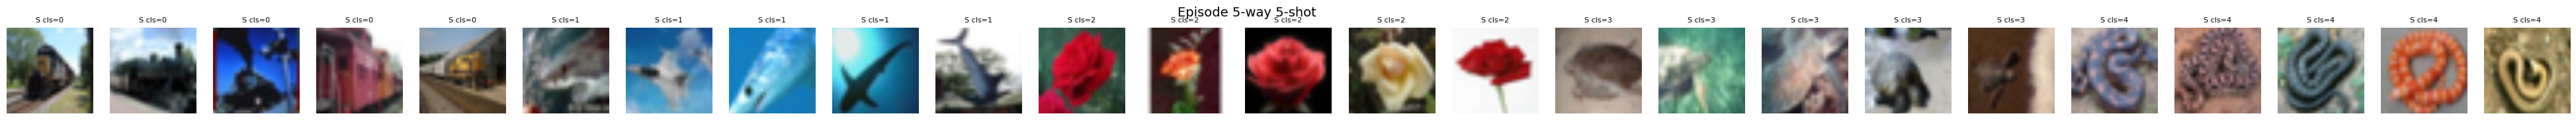

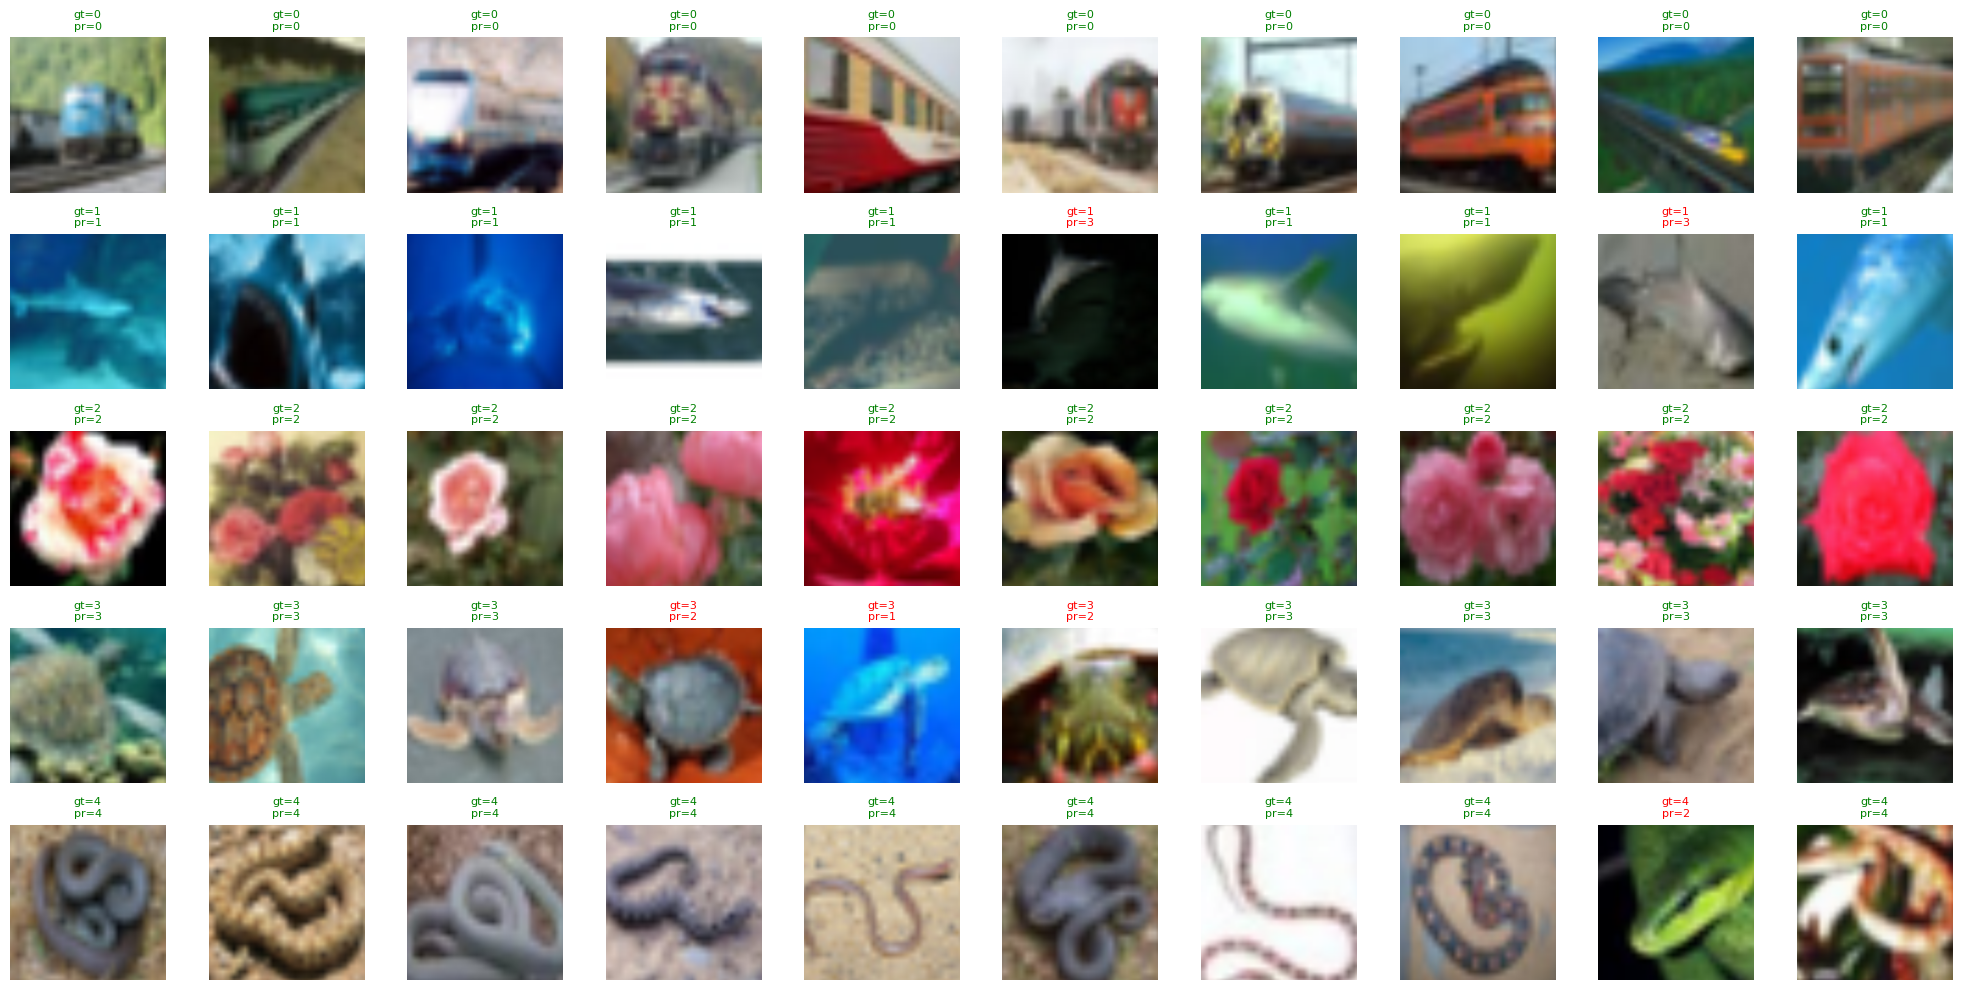

In [13]:
@torch.no_grad()
def show_episode(model, dataset, n_way=5, k_shot=1, q_query=5, n_cols=10):
    """
    Mostra un episodio Few-Shot:
    - prima riga = support set
    - query set suddiviso su più righe (max n_cols immagini per riga)
    """
    chosen, s_idx, q_idx = sample_episode_indices(n_way, k_shot, q_query)
    Sx, Sy, Qx, Qy = make_episode_tensors(dataset, chosen, s_idx, q_idx)
    logits, classes = model(Sx, Sy, Qx)
    preds = logits.argmax(1).cpu()

    # denormalizzazione per plotting
    denorm = lambda t: (t * torch.tensor(IMAGENET_STD).view(3,1,1) +
                        torch.tensor(IMAGENET_MEAN).view(3,1,1)).clamp(0,1)

    n_support, n_query = len(Sx), len(Qx)

    # --- SUPPORT SET (prima riga) ---
    fig, ax_sup = plt.subplots(1, n_support, figsize=(2*n_support, 2))
    if n_support == 1:
        ax_sup = [ax_sup]
    for i in range(n_support):
        ax = ax_sup[i]
        ax.imshow(denorm(Sx[i]).permute(1,2,0))
        ax.axis("off")
        ax.set_title(f"S cls={Sy[i].item()}", fontsize=8)
    plt.suptitle(f"Episode {n_way}-way {k_shot}-shot", fontsize=14)
    plt.show()

    # --- QUERY SET (diviso in righe) ---
    n_rows = int(np.ceil(n_query / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
    axes = np.atleast_2d(axes)

    for j in range(n_query):
        r, c = divmod(j, n_cols)
        ax = axes[r, c]
        ax.imshow(denorm(Qx[j]).permute(1,2,0))
        ax.axis("off")
        gt, pr = Qy[j].item(), preds[j].item()
        color = "green" if gt == pr else "red"
        ax.set_title(f"gt={gt}\npr={pr}", fontsize=8, color=color)

    # nascondi celle vuote
    for j in range(n_query, n_rows*n_cols):
        r, c = divmod(j, n_cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

show_episode(model, ds_novel, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY)

---

## **3. Final Considerations**

SimpleShot assumes access to a strong, well-calibrated encoder and benefits from using the same preprocessing that the encoder saw during pretraining.

Centering with $\mu_{\text{base}}$ **presumes that base and novel distributions are not wildly misaligned**: on small images like CIFAR-100 and with robust backbones, the centering step may yield marginal or inconsistent gains, which is precisely why the ablation is informative.

Unlike ProtoNets, there is **no episodic training** here: the method relies entirely on the frozen encoder and per-episode prototype construction. If one wishes to close any potential gap, partial fine-tuning of the last residual block or switching to cosine-tuned heads can be explored, but that moves away from the strictly non-parametric test-time setting.